# CycleGAN

Based on:
 - https://github.com/AYLIEN/gan-intro/blob/master/gan.py
 - https://hardikbansal.github.io/CycleGANBlog/

Dataset:
 - http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/assignments/a4-code.zip

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#tf.enable_eager_execution()
#tf.executing_eagerly()

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

Import and preview the Apple and Windows emojis dataset.

In [2]:
def _parse_function(filename, channels=4, resize=None):
    """ Get tensor from filename """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_png(image_string, channels=channels) # RGBA images
    
    if resize:
        image_decoded = tf.image.resize_images(image_decoded, resize)
    
    # Normalize to be between -1 and 1
    image_cast = tf.cast(image_decoded, tf.float32)
    image_norm = tf.subtract(tf.divide(image_cast, [127.5]), 1)
    
    return image_norm

def train_input_fn(batch_size=1, channels=4, resize=None):
    """ Get tensors of training data for image sets A and B """
    apple = tf.data.Dataset.list_files("emojis/Apple/*.png").map(lambda x: _parse_function(x,channels,resize))
    windows = tf.data.Dataset.list_files("emojis/Windows/*.png").map(lambda x: _parse_function(x,channels,resize))
    
    apple_iter = apple.shuffle(10000).batch(batch_size).make_initializable_iterator()
    windows_iter = windows.shuffle(10000).batch(batch_size).make_initializable_iterator()
    return {
        'A': apple_iter,
        'B': windows_iter
    }

def test_input_fn(batch_size=1, channels=4, resize=None, seed=42):
    """ Get tensors of testing data for image sets A and B """
    apple = tf.data.Dataset.list_files("emojis/Test_Apple/*.png").map(lambda x: _parse_function(x,channels,resize))
    windows = tf.data.Dataset.list_files("emojis/Test_Windows/*.png").map(lambda x: _parse_function(x,channels,resize))
    
    apple_iter = apple.shuffle(10000,seed=seed).batch(batch_size).make_initializable_iterator()
    windows_iter = windows.shuffle(10000,seed=seed).batch(batch_size).make_initializable_iterator()
    return {
        'A': apple_iter,
        'B': windows_iter
    }

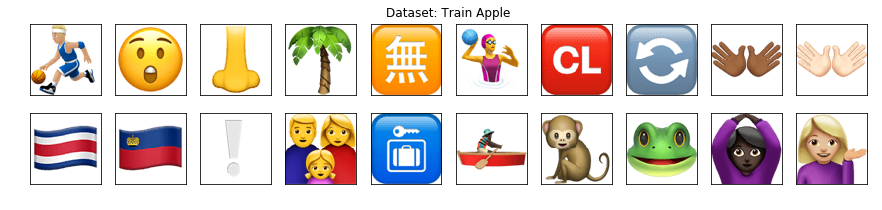

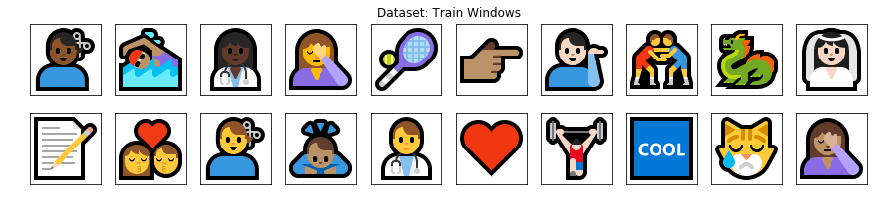

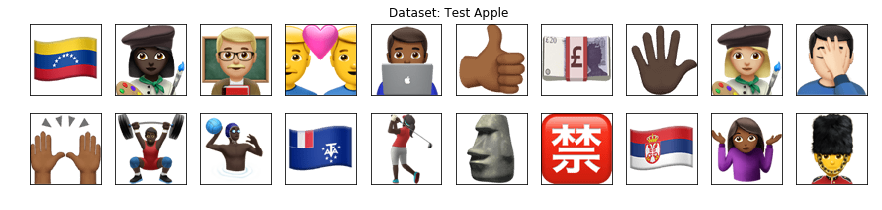

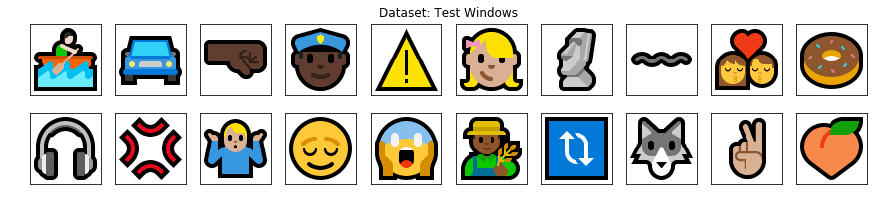

In [3]:
def denormalize(image):
    """ Take TensorFlow tensor and get a 8-bit (0-255) image again """
    return tf.cast(tf.multiply(tf.add(image,1),127.5), tf.uint8)

def show(titles, input_data, num=20, cols=10):
    with tf.Session() as sess:
        """ Display the first images in a given dataset as a sanity check """
        assert len(titles) == len(input_data)
        for i, (name,tensor) in enumerate(input_data.items()): # Plot each provided dataset (probably 2)
            sess.run(tensor.initializer)
            next_image = tensor.get_next()
            
            fig = plt.figure(figsize=(15, 3))
            plt.axis('off')
            plt.title("Dataset: "+titles[i])
            
            # If we don't denormalize it, the coloring will be off
            denormalized = denormalize(next_image)

            for j in range(num):
                next_image = sess.run(denormalized)[0] # Only take first image in batch

                ax = fig.add_subplot(np.ceil(num/cols), cols, j+1)
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(next_image)

        plt.show()

show(["Train Apple", "Train Windows"], train_input_fn())
show(["Test Apple", "Test Windows"], test_input_fn())

Implementing the GAN

In [4]:
def conv2d(name, inputs, num_outputs, kernel_size, stride, padding, stddev=0.02, activation=tf.nn.relu):
    with tf.variable_scope(name):
        return tf.contrib.layers.conv2d(inputs, num_outputs, kernel_size, stride, padding,
                                        activation_fn=activation,
                                        weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                        biases_initializer=tf.constant_initializer(0.0))

def deconv2d(name, inputs, num_outputs, kernel_size, stride, padding, stddev=0.02, activation=tf.nn.relu):
    with tf.variable_scope(name):
        return tf.contrib.layers.conv2d_transpose(inputs, num_outputs, kernel_size, stride, padding,
                                                  activation_fn=activation,
                                                  weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                                  biases_initializer=tf.constant_initializer(0.0))

def resnet(name, inputs, num_outputs):
    with tf.variable_scope(name):
        r = tf.pad(inputs, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")
        r = conv2d("c1", r, num_outputs, 3, 1, "VALID")
        r = tf.pad(r, [[0,0], [1,1], [1,1], [0,0]], "REFLECT")
        r = conv2d("c2", r, num_outputs, 3, 1, "VALID", activation=None)
        return tf.nn.relu(r + inputs)

class CycleGAN:
    def __init__(self,
                 num_epochs=100,
                 batch_size=16,
                 img_width=72,
                 img_height=72,
                 img_layers=4,
                 generator_residual_blocks=3,
                 log_dir="logs",
                 check_dir="models",
                 eval_images=3, # Probably has to be smaller than the batch size
                 restore=True):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.img_layers = img_layers
        self.log_dir = log_dir
        self.check_dir = check_dir
        self.eval_images = eval_images
        self.restore = restore
        self.data_format = 'channels_last'
        self.generator_residual_blocks = generator_residual_blocks

    def create_generator(self, name, input_layer):
        l = tf.keras.layers
        ngf = 8 # Filter depth for generator, what was used in tutorial

        with tf.variable_scope(name):
            # TODO
            # - add instance norm, batch norm, group norm or something
            # - add leaky ReLU
            g_pad = tf.pad(input_layer, [[0,0],[3,3],[3,3],[0,0]], "REFLECT")
            g_c1 = conv2d("c1", g_pad, ngf,   7, 1, "VALID")
            g_c2 = conv2d("c2", g_c1,  ngf*2, 3, 2, "SAME")
            g_c3 = conv2d("c3", g_c2,  ngf*4, 3, 2, "SAME")

            assert self.generator_residual_blocks > 0
            g_r = resnet("r1", g_c3, ngf*4)
            for i in range(self.generator_residual_blocks-1):
                g_r = resnet("r"+str(i+2), g_r, ngf*4)

            g_c4 = deconv2d("c4", g_r,  ngf*2,           3, 2, "SAME")
            g_c5 = deconv2d("c5", g_c4, ngf,             3, 2, "SAME")
            g_c6 = conv2d("c6",   g_c5, self.img_layers, 7, 1, "SAME", activation=None)

            return tf.nn.tanh(g_c6, "t1") # Maybe not needed since I used ReLU for all of them?

    def create_discriminator(self, name, input_layer):
        l = tf.keras.layers
        ndf = 16 # Filter depth for discriminator, what was used in tutorial

        with tf.variable_scope(name):
            d_c1 = conv2d("c1", input_layer, ndf,   4, 2, "SAME")
            d_c2 = conv2d("c2", d_c1,        ndf*2, 4, 2, "SAME")
            d_c3 = conv2d("c3", d_c2,        ndf*4, 4, 2, "SAME")
            d_c4 = conv2d("c4", d_c3,        ndf*8, 4, 1, "SAME")
            d_c5 = conv2d("c5", d_c4,        1,     4, 1, "SAME", activation=None)
            return d_c5

    def cyclegan_model(self):
        # Get image data directly from features or from "image" if it's a dictionary
        #assert isinstance(input_data, dict) and len(input_data) == 2, "input_data must include both images A and B"
        #image_A = input_data['A']
        #image_B = input_data['B']
        self.image_A = tf.placeholder(tf.float32,
                                      [self.batch_size, self.img_width, self.img_height, self.img_layers],
                                      name="input_A")
        self.image_B = tf.placeholder(tf.float32,
                                      [self.batch_size, self.img_width, self.img_height, self.img_layers],
                                      name="input_B")
        
        # For keeping track of where we are in training, and restoring from checkpoints
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.iteration = tf.Variable(0, name="iteration", trainable=False)

        # Create models
        with tf.variable_scope("Model") as scope:
            # Generator on original images
            self.gen_AtoB = self.create_generator("gen_AtoB", self.image_A)
            self.gen_BtoA = self.create_generator("gen_BtoA", self.image_B)

            # Discriminator on the original real images
            self.disc_Areal = self.create_discriminator("discrim_A", self.image_A)
            self.disc_Breal = self.create_discriminator("discrim_B", self.image_B)

            scope.reuse_variables()

            # Generate from fake back to original (for cycle consistency)
            self.gen_AtoBtoA = self.create_generator("gen_BtoA", self.gen_AtoB) # Reuse weights from BtoA
            self.gen_BtoAtoB = self.create_generator("gen_AtoB", self.gen_BtoA) # Reuse weights from AtoB

            # Discriminators on the generated fake images
            self.disc_Afake = self.create_discriminator("discrim_A", self.gen_AtoB)
            self.disc_Bfake = self.create_discriminator("discrim_B", self.gen_BtoA)

            # TODO
            # - implement the image pool for performance and better convergence

        #
        # Loss functions
        #
        # Generator should by cycle consistent & we want the discriminator to output a 1, i.e. incorrect label
        cyc_loss = tf.reduce_mean(tf.abs(self.image_A-self.gen_AtoBtoA)) + \
                   tf.reduce_mean(tf.abs(self.image_B-self.gen_BtoAtoB))
        g_loss_A = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(self.disc_Afake,1))
        g_loss_B = cyc_loss*10 + tf.reduce_mean(tf.squared_difference(self.disc_Bfake,1))

        # Discriminator should correctly classify the original real images and the generated fake images
        d_loss_A = (tf.reduce_mean(tf.square(self.disc_Afake)) +
                         tf.reduce_mean(tf.squared_difference(self.disc_Areal,1)))/2
        d_loss_B = (tf.reduce_mean(tf.square(self.disc_Bfake)) +
                         tf.reduce_mean(tf.squared_difference(self.disc_Breal,1)))/2

        #
        # Variables
        #
        variables = tf.trainable_variables()
        d_A_vars = [v for v in variables if 'discrim_A' in v.name]
        g_A_vars = [v for v in variables if 'gen_A' in v.name]
        d_B_vars = [v for v in variables if 'discrim_B' in v.name]
        g_B_vars = [v for v in variables if 'gen_B' in v.name]

        #
        # Optimization
        #
        self.learningRate = tf.placeholder(tf.float32, shape=[], name="learningRate")
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate, beta1=0.5)
        self.d_A_trainer = optimizer.minimize(d_loss_A, var_list=d_A_vars)
        self.d_B_trainer = optimizer.minimize(d_loss_B, var_list=d_B_vars)
        self.g_A_trainer = optimizer.minimize(g_loss_A, var_list=d_A_vars)
        self.g_B_trainer = optimizer.minimize(g_loss_B, var_list=d_B_vars)
        
        #
        # Summaries for TensorBoard
        #
        self.g_A_loss_summ = tf.summary.scalar("g_A_loss", g_loss_A)
        self.g_B_loss_summ = tf.summary.scalar("g_B_loss", g_loss_B)
        self.d_A_loss_summ = tf.summary.scalar("d_A_loss", d_loss_A)
        self.d_B_loss_summ = tf.summary.scalar("d_B_loss", d_loss_B)
        
        #
        # For evaluation
        #
        # When running this in the session, change the feed_dict to feed in the evaluation
        # images rather than the training images.
        #
        realA = denormalize(self.image_A)
        realB = denormalize(self.image_B)
        fakeA = denormalize(self.gen_BtoA)
        fakeB = denormalize(self.gen_AtoB)
        
        self.eval_realA_summ = tf.summary.image("real_A", realA, self.eval_images)
        self.eval_realB_summ = tf.summary.image("real_B", realB, self.eval_images)
        self.eval_fakeA_summ = tf.summary.image("fake_A", fakeA, self.eval_images)
        self.eval_fakeB_summ = tf.summary.image("fake_B", fakeB, self.eval_images)
    
    def run(self):
        # Define the networks
        self.cyclegan_model()

        # Saving content checkpoints and summaries to disk
        saver = tf.train.Saver()
        writer = tf.summary.FileWriter(self.log_dir)

        if not os.path.exists(self.check_dir):
            os.makedirs(self.check_dir)

        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            tf.local_variables_initializer().run()
            tf.global_variables_initializer().run()

            # Get training input images
            input_data = train_input_fn(self.batch_size,
                                        channels=self.img_layers,
                                        resize=[self.img_width,self.img_height])
            image_A_iter = input_data['A']
            image_B_iter = input_data['B']
            
            # Get evaluation images
            eval_input_data = test_input_fn(self.batch_size, # "batch" is number of images we want
                                        channels=self.img_layers,
                                        resize=[self.img_width,self.img_height])
            eval_image_A_iter = eval_input_data['A']
            eval_image_B_iter = eval_input_data['B']

            # Restore from last checkpoint
            chkpt_fname = tf.train.latest_checkpoint(self.check_dir)
            if self.restore and chkpt_fname is not None:
                saver.restore(sess, chkpt_fname)
            
            writer.add_graph(sess.graph)

            # Run the training
            for epoch in range(sess.run(self.global_step),self.num_epochs):
                print("Epoch:", epoch)
                saver.save(sess, os.path.join(self.check_dir, "cyclegan"), global_step=epoch)
                
                # Reinitialize at the beginning of each epoch
                sess.run([image_A_iter.initializer, image_B_iter.initializer])
                next_image_A = image_A_iter.get_next()
                next_image_B = image_B_iter.get_next()
                
                # Decaying learning rate
                if epoch < 100:
                    currentLearningRate = 0.0002
                else:
                    currentLearningRate = 0.0002 - 0.0002*(epoch-100)/100 # From tutorial

                while True:
                    iteration = sess.run(self.iteration)
                    
                    try:
                        t = time.time()
                        
                        image_A, image_B = sess.run([next_image_A, next_image_B])
                        
                        # Make sure we have a full batch
                        if image_A.shape[0] != self.batch_size or image_B.shape[0] != self.batch_size:
                            print("Incorrect batch sizes:", image_A.shape[0], image_B.shape[0])
                            break
                        
                        # Optimize gen_AtoB
                        _, fakeB, summ = sess.run([self.g_A_trainer, self.gen_AtoB, self.g_A_loss_summ], feed_dict={
                                                     self.image_A: image_A,
                                                     self.image_B: image_B,
                                                     self.learningRate: currentLearningRate
                                                 })
                        writer.add_summary(summ, iteration)

                        # Optimize discrim_B
                        _, summ = sess.run([self.d_B_trainer, self.d_B_loss_summ], feed_dict={
                                                     self.image_A: image_A,
                                                     self.image_B: image_B,
                                                     self.learningRate: currentLearningRate
                                                 })
                        writer.add_summary(summ, iteration)

                        # Optimize gen_BtoA
                        _, fakeA, summ = sess.run([self.g_B_trainer, self.gen_BtoA, self.g_B_loss_summ], feed_dict={
                                                     self.image_A: image_A,
                                                     self.image_B: image_B,
                                                     self.learningRate: currentLearningRate
                                                 })
                        writer.add_summary(summ, iteration)

                        # Optimize discrim_A
                        _, summ = sess.run([self.d_A_trainer, self.d_A_loss_summ], feed_dict={
                                                     self.image_A: image_A,
                                                     self.image_B: image_B,
                                                     self.learningRate: currentLearningRate
                                                 })
                        writer.add_summary(summ, iteration)
                        
                        # Log time to execute this step
                        t = time.time() - t
                        summ = tf.Summary(value=[tf.Summary.Value(tag="step_time", simple_value=t)])
                        writer.add_summary(summ, iteration)
                        
                        # We need to flush to disk so I can see the results in TensorBoard
                        if iteration%50 == 0:
                            writer.flush()
                        
                    except tf.errors.OutOfRangeError:
                        break
                    
                    # Evaluation
                    if iteration%100 == 0:
                        # Reset iterators for evaluation
                        sess.run([eval_image_A_iter.initializer, eval_image_B_iter.initializer])
                        eval_image_A, eval_image_B = sess.run([eval_image_A_iter.get_next(), eval_image_B_iter.get_next()])
                        
                        # Generate eval images (real and fake of both A and B)
                        s1, s2, s3, s4 = sess.run([self.eval_realA_summ, self.eval_realB_summ,
                                                  self.eval_fakeA_summ, self.eval_fakeB_summ],
                                                  feed_dict={
                                                     self.image_A: eval_image_A,
                                                     self.image_B: eval_image_B,
                                                     self.learningRate: currentLearningRate
                                                 })
                        
                        writer.add_summary(s1, iteration)
                        writer.add_summary(s2, iteration)
                        writer.add_summary(s3, iteration)
                        writer.add_summary(s4, iteration)
                    
                    # Increment iteration since we've finished another image
                    sess.run(tf.assign(self.iteration, iteration+1))
                
                # Increment global step since we've finished another epoch
                sess.run(tf.assign(self.global_step, epoch+1))

        # Visually evaluate samples
        #predictions = gan.predict(input_fn=lambda: test_input_fn(num_epochs, batch_size))

        # TODO: Plot 'em

In [ ]:
g = CycleGAN()
g.run()

INFO:tensorflow:Restoring parameters from models/cyclegan-3
Epoch: 3
Incorrect batch sizes: 16 14
Epoch: 4
